In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

# Load datasets

In [2]:
playerdata_1718season = '.\playerstatsbygame_20172018_regularseason.csv'
playerseason_data = '.\Seasons_Stats.csv'
salarydata = './nba_salaries_1990_to_2018.csv'
rpm_data = './RPM_data.xlsx'

playerstats_1718 = pd.read_csv(playerdata_1718season)
playerseasondata = pd.read_csv(playerseason_data)
salarydata = pd.read_csv(salarydata)
rpmdata = pd.read_excel(rpm_data, sheet_name='Agg')

# EDA

## Creating clean dataset to work with:
- Remap team names to match between stats & salary data
- Combine salary & stats by merging datasets on [Player, Year, Team], for seasons ending 1990-2017
- Get rid of duplicate/unnecessary columns
- Rename columns

In [3]:
# Team names are slightly different between stats & salary, so need to remap before joining:

team_map = {'ATL': 'ATL','BOS': 'BOS','BRK': 'NJN','CHA': 'CHA','CHH': 'CHA','CHI': 'CHI','CHO': 'CHA',
'CLE': 'CLE','DAL': 'DAL','DEN': 'DEN','DET': 'DET','GSW': 'GSW','HOU': 'HOU','IND': 'IND','LAC': 'LAC',
'LAL': 'LAL','MEM': 'MEM','MIA': 'MIA','MIL': 'MIL','MIN': 'MIN','NJN': 'NJN','NOH': 'NOH','NOK': 'NOH',
'NOP': 'NOP','NYK': 'NYK','OKC': 'OKC','ORL': 'ORL','PHI': 'PHI','PHO': 'PHO','POR': 'POR','SAC': 'SAC',
'SAS': 'SAS','SEA': 'SEA','TOR': 'TOR','TOT': 'TOT','UTA': 'UTA','VAN': 'MEM','WAS': 'WAS','WSB': 'WAS'}

playerseasondata['Tm'] = playerseasondata['Tm'].map(team_map)

In [4]:
# combine salary data (1990 - 2017 season end) with stats for one giant player table
# Note, each year is the season end year
# Combine based on player, season, & team (players may have played on >1 team in a season, so this makes sure we join right)

stats = playerseasondata.loc[playerseasondata.loc[:, 'Year'] >= 1990, :]
salary = salarydata.loc[salarydata.loc[:, 'season_end'] <=2017, :]
data = stats.merge(salary, left_on=['Player', 'Year', 'Tm' ], right_on = ['player', 'season_end', 'team'], how='outer')

#get rid of columns I don't want/duplicates and rename existing for clarity

data.drop(['Unnamed: 0','3PAr', 'blank2',
 'blanl', 'BPM', 'DBPM', 'eFG%', 'FTr', 'OBPM', 'team_name', 'VORP', 'WS/48'], axis=1, inplace=True)

data.rename(columns={ '2PA':'2PAttempt', '2P':'2PMade', '2P%':'2Pt%', '3P%':'3Pt%',
 '3PA':'3PtAttempt', '3P':'3PtMade', 'Age':'Age_seasonEnd', 'AST%':'Assist%',
 'AST':'Assists', 'BLK%':'Block%', 'BLK':'Blocks', 'DRB%':'Drebound%',
 'DRB':'Drebounds', 'DWS': 'Dwinshares', 'FG%':'FG%', 'FGA':'Fgattempt', 'FG':'Fgmade',
 'FT%':'FT%', 'FTA':'FTAttempt', 'FT':'FTMade', 'G':'Games',
 'GS':'GamesStarted', 'MP':'MinPlayed', 'ORB':'Offrb', 'ORB%':'OffRb%',
 'OWS': 'OffWinShares', 'PER':'PER', 'PF':'PersonalFouls', 'Player':'Player', 'player':'player',
 'Pos':'Position', 'PTS':'Pts', 'salary':'Salary', 'season_end':'Season_End',
 'season_start':'Season_Start', 'STL%':'Steal%', 'STL':'Steals',
 'team':'Team', 'Tm': 'Stats_Team', 'TRB%':'TotalRbnd%', 'TRB':'TotalRbnds',
 'TS%':'TS%', 'TOV':'Turnover', 'TOV%':'Turnover%','USG%':'Usg%', 'WS':'WinShares', 'Year': 'Stats_SeasonEnd'}, inplace=True)

In [5]:
#Build a dictionary of full team names for use later

team_fullnames = {'LAL': 'LA Lakers', 'PHO': 'Phoenix Suns' , 'DAL':'Dallas Mavericks' , 
                  'MIA': 'Miami Heat', 'CLE': 'Cleveland Cavaliers', 'WAS': 'Washington Wizards',
                  'CHI': 'Chicago Bulls', 'GSW': 'Golden State Warriors', 'IND': 'Indiana Pacers',
                  'BOS': 'Boston Celtics', 'HOU': 'Houston Rockets', 'SAC': 'Sacramento Kings',
                  'ORL': 'Orlando Magic', 'NOH': 'New Orleans Pelicans/Hornets', 'TOR': 'Toronto Raptors',
                  'CHA': 'Charlotte Hornets', 'POR': 'Portland Trailblazers', 'DET': 'Detroit Pistons',
                  'PHI': 'Philadelphia 76ers', 'MIL': 'Milwaukee Bucks', 'DEN': 'Denver Nuggets', 
                  'OKC': 'OKC Thunder', 'NJN': 'Brooklyn Nets', 'LAC': 'Los Angeles Clippers', 'ATL': 'Atlanta Hawks', 
                  'MEM': 'Memphis Grizzlies', 'UTA': 'Utah Jazz','MIN': 'Minnesota Timberwolves', 'NYK': 'New York Knicks',
                  'SAS': 'San Antonio Spurs'}

### Missing values:
- There are a lot
- Fill in missing stats values with '0', because the dataset loaded in any 0s as NaN (eg, player played 0 minutes)
- Impute missing salary values by adding the average salary of the player if it exists

In [6]:
data.isnull().sum()

Stats_SeasonEnd    1446
Player             1446
Position           1446
Age_seasonEnd      1446
Stats_Team         1446
Games              1446
GamesStarted       1446
MinPlayed          1446
PER                1451
TS%                1517
OffRb%             1451
Drebound%          1451
TotalRbnd%         1451
Assist%            1451
Steal%             1451
Block%             1451
Turnover%          1504
Usg%               1451
OffWinShares       1446
Dwinshares         1446
WinShares          1446
Fgmade             1446
Fgattempt          1446
FG%                1526
3PtMade            1446
3PtAttempt         1446
3Pt%               4133
2PMade             1446
2PAttempt          1446
2Pt%               1552
FTMade             1446
FTAttempt          1446
FT%                2089
Offrb              1446
Drebounds          1446
TotalRbnds         1446
Assists            1446
Steals             1446
Blocks             1446
Turnover           1446
PersonalFouls      1446
Pts             

In [7]:
#For NaN stats values, a '0' is an acceptable number, so will fill in missing stats with 0.

fillwithzero = ['Games',
 'GamesStarted',
 'MinPlayed',
 'PER',
 'TS%',
 'OffRb%',
 'Drebound%',
 'TotalRbnd%',
 'Assist%',
 'Steal%',
 'Block%',
 'Turnover%',
 'Usg%',
 'WinShares',
 'Fgmade',
 'Fgattempt',
 'FG%',
 '3PtMade',
 '3PtAttempt',
 '3Pt%',
 '2PMade',
 '2PAttempt',
 '2Pt%',
 'FTMade',
 'FTAttempt',
 'FT%',
 'Offrb',
 'Drebounds',
 'TotalRbnds',
 'Assists',
 'Steals',
 'Blocks',
 'Turnover',
 'PersonalFouls',
 'Pts']

data[fillwithzero] = data[fillwithzero].fillna(value=0)

Replace missing salary values with each player's average salary:

In [8]:
data.loc[:, ['Stats_SeasonEnd', 'Salary', 'Player']].groupby('Stats_SeasonEnd').count()

,Salary,Player
Stats_SeasonEnd,,
1990.0,0,459
1991.0,333,441
1992.0,320,458
1993.0,316,449
1994.0,335,481
1995.0,289,452
1996.0,353,545
1997.0,352,574
1998.0,321,547


In [9]:
playeravgsal = data.loc[:, ['Player', 'Salary']].groupby('Player').mean()
playeravgsal = playeravgsal.to_dict()
playeravgsal = playeravgsal['Salary']

data.Salary = data.Salary.fillna(data.Player.map(playeravgsal))

salaryplayercount = data.loc[:, ['Stats_SeasonEnd', 'Salary', 'Player']].groupby('Stats_SeasonEnd').count()
salaryplayercount['ratio'] = salaryplayercount['Salary'] / salaryplayercount['Player']
salaryplayercount

#Majority of rows now have a salary attached

,Salary,Player,ratio
Stats_SeasonEnd,,,
1990.0,344,459,0.749455
1991.0,405,441,0.918367
1992.0,440,458,0.960699
1993.0,436,449,0.971047
1994.0,460,481,0.956341
1995.0,435,452,0.962389
1996.0,527,545,0.966972
1997.0,552,574,0.961672
1998.0,538,547,0.983547


In [10]:
#Add shifted salary & win share columns, so we can compare stats to a player's next year salary and impact
data['next_season_salary'] = data.groupby(['Player'])['Salary'].shift(-1)
data['next_season_winshares'] = data.groupby(['Player'])['WinShares'].shift(-1)
data['next_season_off_winshares'] = data.groupby(['Player'])['OffWinShares'].shift(-1)
data['next_season_def_winshares'] = data.groupby(['Player'])['Dwinshares'].shift(-1)

In [11]:
#Add a column for # of years player has been in league
player_min_year = pd.DataFrame(playerseasondata.groupby('Player')['Year'].min())
player_min_year = player_min_year.to_dict()
player_min_year = player_min_year['Year']
data['Player_first_year'] = data.Player.map(player_min_year)
data['Years_Playing'] = data['Stats_SeasonEnd'] - data['Player_first_year']

Setup some dummy variables for position:

In [12]:
data.Position.value_counts()

position_map = {'PF': 1, 'PG': 2, 'C': 3, 'SG': 4, 'SF': 5, 'PG-SG': 6, 'SG-PG': 6, 'SG-SF': 7, 'SF-SG': 7,
               'C-PF': 8, 'PF-SF': 9, 'PF-C':8, 'SF-PF': 9, 'SG-PF': 10, 'C-SF': 11, 'PG-SF':1}

data['Position_Mapped'] = data['Position'].map(position_map)

In [13]:
# Add a column with that year's salary cap (source: basketball-reference.com)
# Add a column for salary as % of salary cap

salary_cap_by_year = {1990: 9802000,1991: 11871000,1992: 12500000,1993: 14000000,
1994: 15175000,1995: 15964000,1996: 23000000,1997: 24363000,1998: 26900000,1999: 30000000,
2000: 34000000,2001: 35500000,2002: 42500000,2003: 40271000,2004: 43840000,2005: 43870000,
2006: 49500000,2007: 53135000,2008: 55630000,2009: 58680000,2010: 57700000,2011: 58044000,
2012: 58044000,2013: 58044000,2014: 58679000,2015: 63065000,2016: 70000000,2017: 94143000}
data['Season_Salary_Cap'] = data['Stats_SeasonEnd'].map(salary_cap_by_year)
data['Salary_as_percent_of_cap'] = data['Salary'] / data['Season_Salary_Cap']
data['next_season_salary_as_percent_of_cap'] = data.groupby(['Player'])['Salary_as_percent_of_cap'].shift(-1)

## More EDA

- Data shape
- Data types
- Count of null values by column
- Basic summary statistics
- Number of unique values for each column
- Plot of the distribution of each column (e.g. histogram, bar plot, or box plot)
- Scatterplot of each column with salaryEDA!

In [14]:
print("Shape:", data.shape, '\n')
print("Types:", data.dtypes, '\n')
print("Null counts:", data.isnull().sum(), '\n')

Shape: (16564, 57) 

Types: Stats_SeasonEnd                         float64
Player                                   object
Position                                 object
Age_seasonEnd                           float64
Stats_Team                               object
Games                                   float64
GamesStarted                            float64
MinPlayed                               float64
PER                                     float64
TS%                                     float64
OffRb%                                  float64
Drebound%                               float64
TotalRbnd%                              float64
Assist%                                 float64
Steal%                                  float64
Block%                                  float64
Turnover%                               float64
Usg%                                    float64
OffWinShares                            float64
Dwinshares                              float64
WinShares   

In [15]:
data.describe()

,Stats_SeasonEnd,Age_seasonEnd,Games,GamesStarted,MinPlayed,PER,TS%,OffRb%,Drebound%,TotalRbnd%,...,next_season_salary,next_season_winshares,next_season_off_winshares,next_season_def_winshares,Player_first_year,Years_Playing,Position_Mapped,Season_Salary_Cap,Salary_as_percent_of_cap,next_season_salary_as_percent_of_cap
count,15118.000000,15118.000000,16564.000000,16564.000000,16564.000000,16564.000000,16564.000000,16564.000000,16564.000000,16564.000000,...,1.265800e+04,12828.000000,12828.000000,12828.000000,15118.000000,15118.000000,15118.000000,1.511800e+04,14680.000000,12658.000000
mean,2004.209353,26.980553,44.136078,21.101847,1032.780427,11.322996,0.457026,5.489181,12.738493,9.115902,...,3.424576e+06,2.541916,1.329755,1.210766,1999.232570,4.976783,2.995304,4.309407e+07,0.076255,0.080310
std,8.001655,4.149695,28.745473,27.781173,932.186372,6.957249,0.171681,5.140127,7.422056,5.625334,...,3.901391e+06,3.003976,2.062033,1.232457,9.021815,4.608485,1.491097,2.055203e+07,0.082062,0.081389
min,1990.000000,18.000000,0.000000,0.000000,0.000000,-90.600000,0.000000,0.000000,0.000000,0.000000,...,5.000000e+03,-1.600000,-2.800000,-1.000000,1957.000000,0.000000,1.000000,9.802000e+06,0.000055,0.000055
25%,1997.000000,24.000000,17.000000,0.000000,160.000000,8.400000,0.450000,1.800000,8.300000,5.400000,...,9.073307e+05,0.200000,0.000000,0.300000,1992.000000,1.000000,2.000000,2.436300e+07,0.020643,0.023529
50%,2005.000000,26.000000,48.000000,5.000000,800.000000,12.100000,0.509000,4.300000,12.100000,8.400000,...,2.000000e+06,1.500000,0.600000,0.800000,1999.000000,4.000000,3.000000,4.387000e+07,0.050254,0.055624
75%,2011.000000,30.000000,72.000000,38.000000,1747.250000,15.300000,0.548000,8.500000,17.600000,13.000000,...,4.419539e+06,3.900000,2.100000,1.800000,2006.000000,8.000000,4.000000,5.804400e+07,0.102805,0.108723
max,2017.000000,44.000000,85.000000,83.000000,3533.000000,129.100000,1.136000,100.000000,100.000000,100.000000,...,3.314000e+07,20.400000,14.900000,9.100000,2017.000000,47.000000,11.000000,9.414300e+07,1.237122,1.237122


In [16]:
for col in data.columns:
    print(col, data.loc[:, col].nunique())

Stats_SeasonEnd 28
Player 2290
Position 16
Age_seasonEnd 27
Stats_Team 33
Games 86
GamesStarted 84
MinPlayed 3140
PER 512
TS% 570
OffRb% 291
Drebound% 392
TotalRbnd% 304
Assist% 507
Steal% 107
Block% 127
Turnover% 388
Usg% 394
OffWinShares 167
Dwinshares 87
WinShares 197
Fgmade 799
Fgattempt 1515
FG% 468
3PtMade 240
3PtAttempt 552
3Pt% 398
2PMade 738
2PAttempt 1333
2Pt% 458
FTMade 568
FTAttempt 696
FT% 626
Offrb 350
Drebounds 700
TotalRbnds 939
Assists 711
Steals 217
Blocks 256
Turnover 322
PersonalFouls 331
Pts 1844
player 2161
Salary 6339
Season_End 27
Season_Start 27
Team 30
next_season_salary 5256
next_season_winshares 194
next_season_off_winshares 162
next_season_def_winshares 86
Player_first_year 46
Years_Playing 48
Position_Mapped 11
Season_Salary_Cap 26
Salary_as_percent_of_cap 9511
next_season_salary_as_percent_of_cap 8317


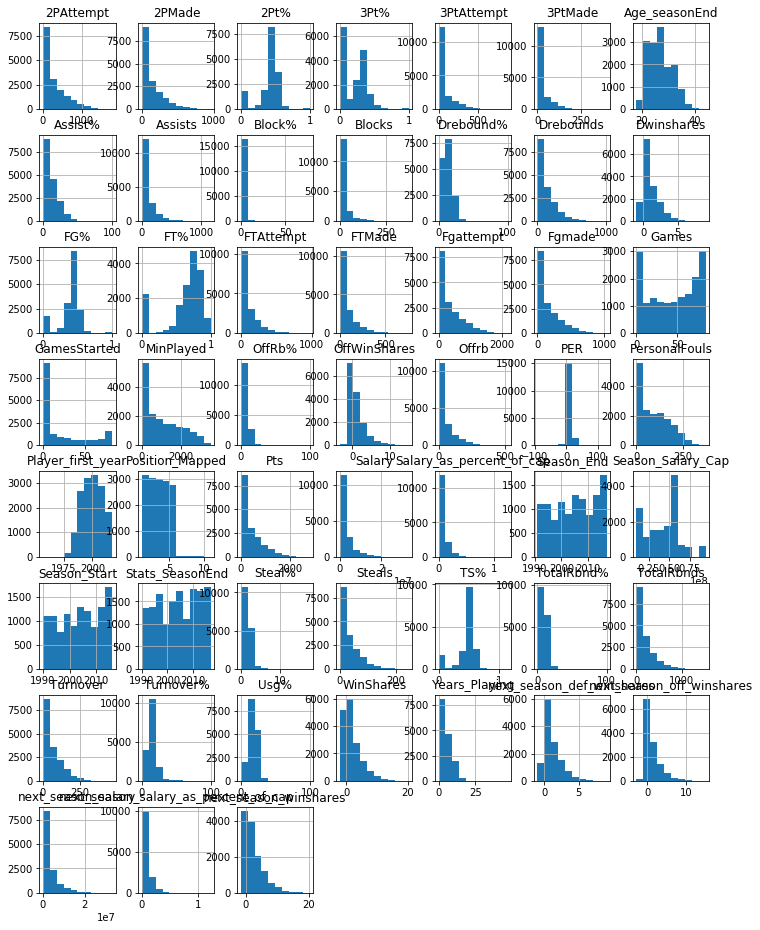

In [17]:
data.hist(figsize=(12,16));

In [32]:
box_score_features = ['Age_seasonEnd','Games','GamesStarted','MinPlayed',
                      'Fgmade','Fgattempt','3PtMade','3PtAttempt','2PMade','2PAttempt',
                      'FTMade','FTAttempt','Offrb','Drebounds','TotalRbnds','Assists',
                      'Steals','Blocks','Turnover','PersonalFouls','Pts','Position_Mapped', 'Years_Playing']
box_score_percentages = ['OffRb%','Drebound%','TotalRbnd%','Assist%','Steal%','Block%','Turnover%','Usg%',
                         '3Pt%','2Pt%','FT%']
combo_features = ['PER','TS%','Usg%','OffWinShares','Dwinshares','WinShares']

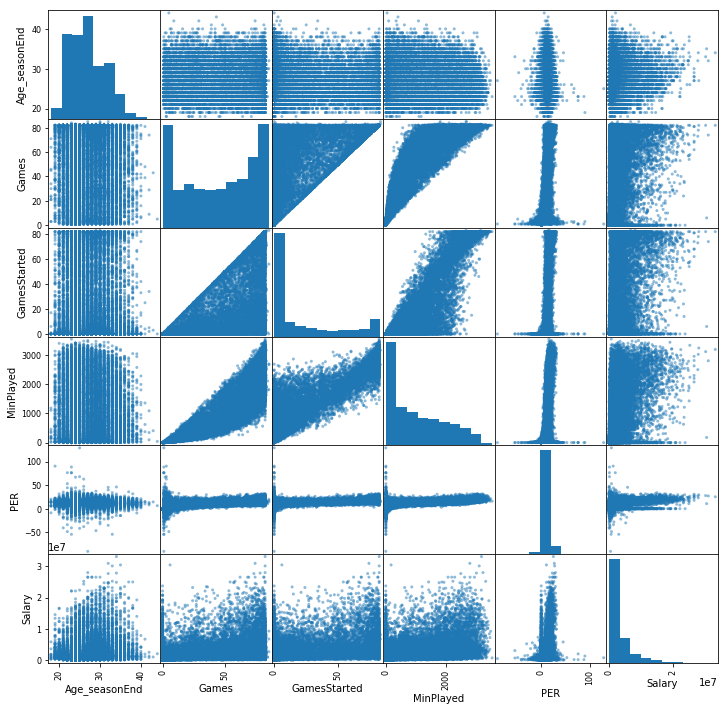

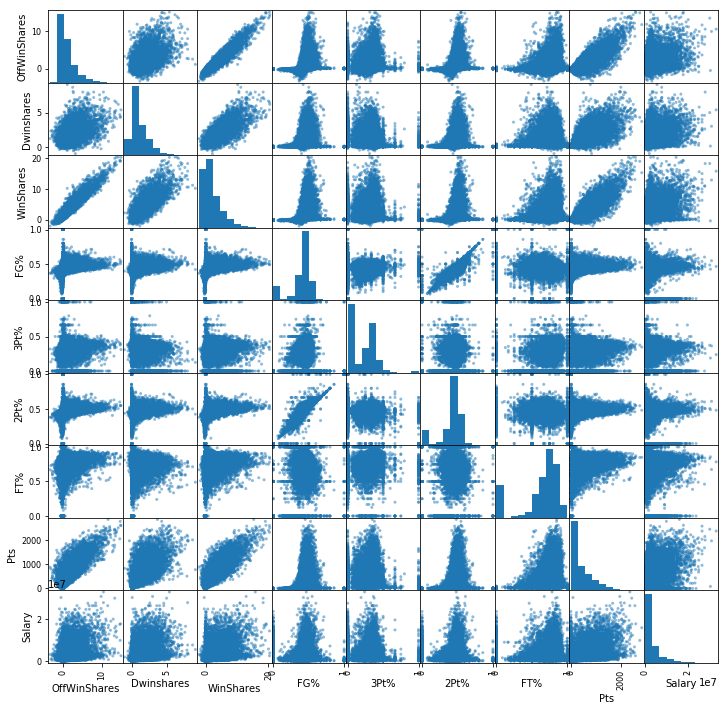

In [19]:
#running several scatter_matrix plots because it's a lot to look at...
pd.plotting.scatter_matrix(data.loc[:, ['Age_seasonEnd', 'Games', 'GamesStarted',
 'MinPlayed', 'PER', 'Salary']], figsize=(12, 12));

pd.plotting.scatter_matrix(data.loc[:, ['OffWinShares', 'Dwinshares', 'WinShares',
 'FG%', '3Pt%','2Pt%', 'FT%', 'Pts', 'Salary']], figsize=(12, 12));


Starting analysis of salaries:
- Look at salary by season per team, where total salary = sum of all salaries in the table (this may be missing some data, but will have to be OK with that...)

Salary observations:
- Trend should be pretty much the same across teams for full salary, because it should generally equal the cap of the year
- Salary has increased a ton from 1990 - 2017 seasons, which aligns to the salary cap increase: 1990 salary cap was ~11MM
- 2017 season cap was almost $100MM
- Charlotte has a huge gap in the middle because the team moved to New Orleans for a bit

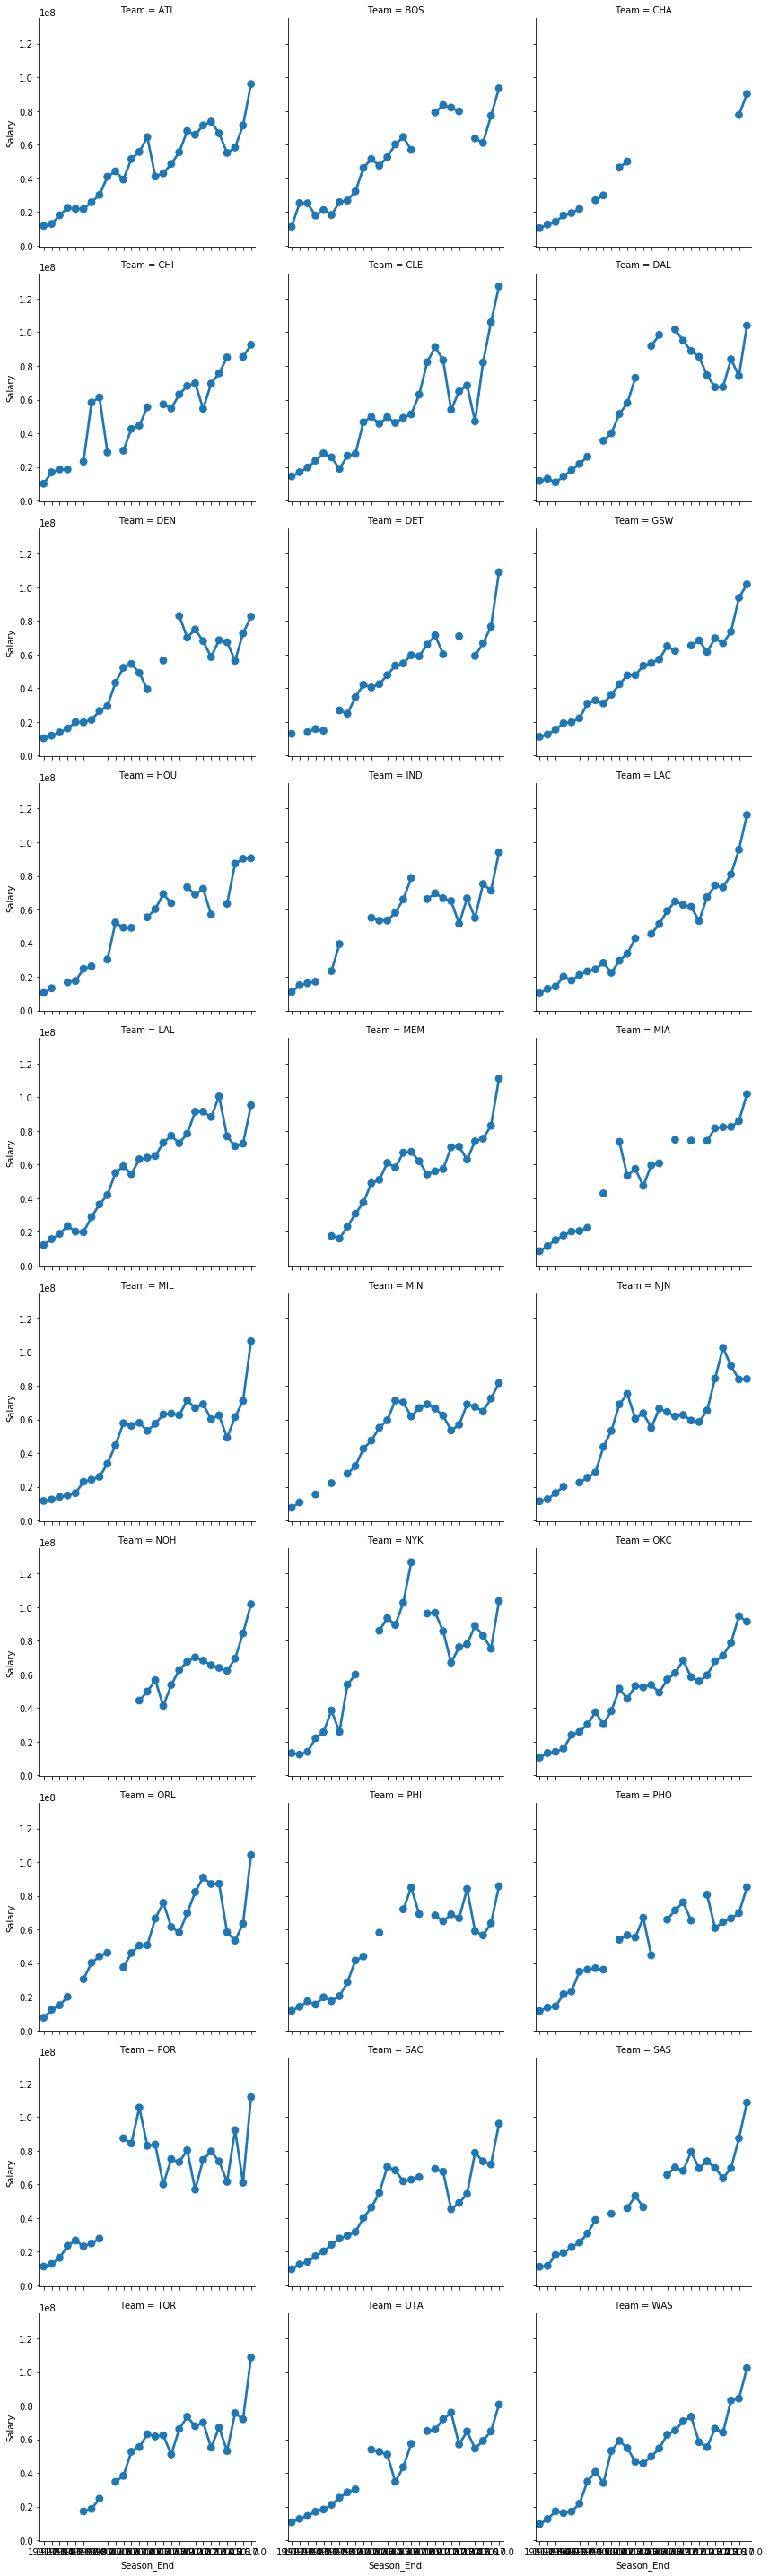

In [20]:
salary_by_year = data.loc[:, ['Team', 'Season_End', 'Salary', 'WinShares']].groupby(['Team', 'Season_End']).sum(axis=1)
salary_by_year.reset_index(inplace=True)

sns.factorplot(x='Season_End', y='Salary', col='Team', col_wrap=3, data=salary_by_year);

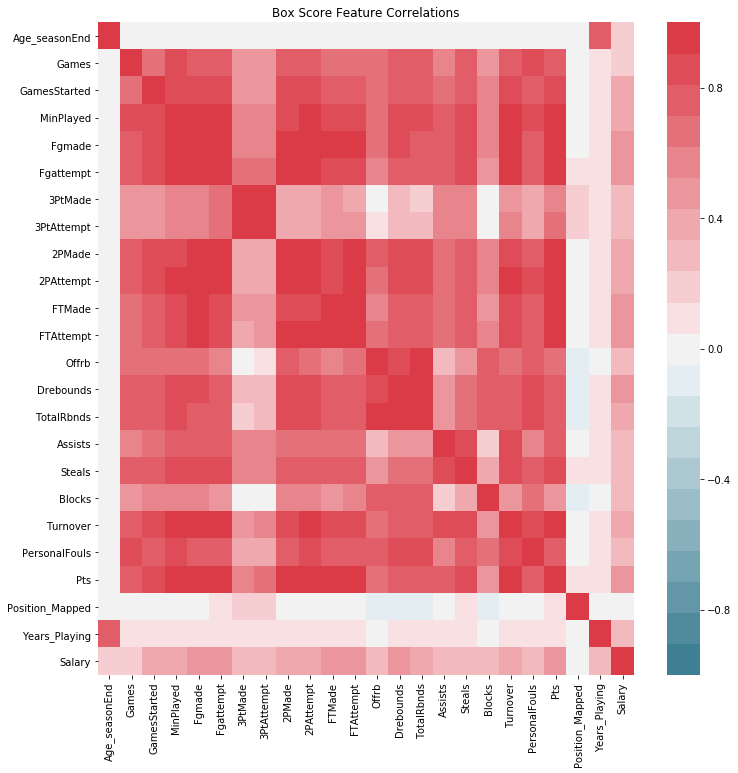

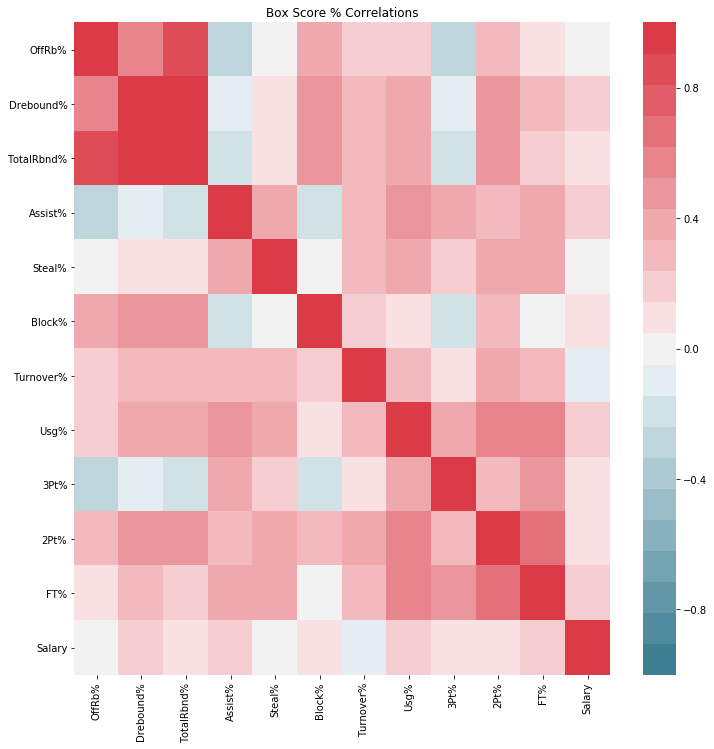

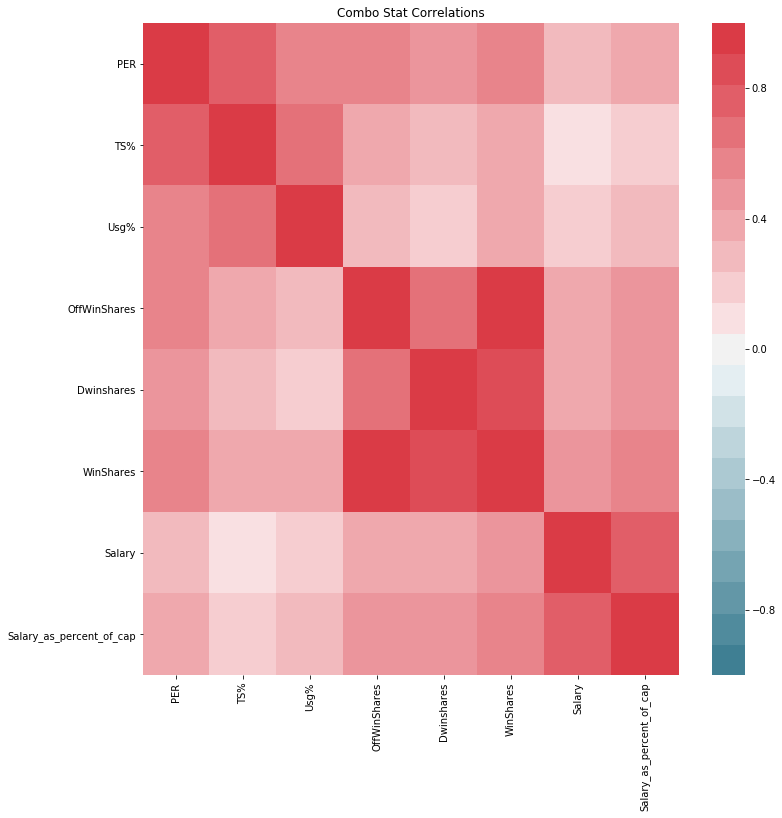

In [72]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data.loc[:, ['Age_seasonEnd','Games','GamesStarted','MinPlayed',
                      'Fgmade','Fgattempt','3PtMade','3PtAttempt','2PMade','2PAttempt',
                      'FTMade','FTAttempt','Offrb','Drebounds','TotalRbnds','Assists',
                      'Steals','Blocks','Turnover','PersonalFouls','Pts','Position_Mapped', 'Years_Playing', 'Salary']].corr(),
            vmin = -1,
           vmax = 1,
           cmap = sns.diverging_palette(220,10,n=21),
           ax=ax);
ax.set_title('Box Score Feature Correlations');

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data.loc[:, ['OffRb%','Drebound%','TotalRbnd%','Assist%','Steal%','Block%','Turnover%','Usg%',
                         '3Pt%','2Pt%','FT%', 'Salary']].corr(),
            vmin = -1,
           vmax = 1,
           cmap = sns.diverging_palette(220,10,n=21),
           ax=ax);
ax.set_title('Box Score % Correlations');


fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data.loc[:, ['PER','TS%','Usg%','OffWinShares','Dwinshares','WinShares', 'Salary', 'Salary_as_percent_of_cap']].corr(),
            vmin = -1,
           vmax = 1,
           cmap = sns.diverging_palette(220,10,n=21),
           ax=ax);
ax.set_title('Combo Stat Correlations');

Correlation observations:
- Not a lot of single values are super strongly correlated to salary; highest are 

Look at relationship of salary vs win shares, which is a stat that tries to quantify a player's impact on his team's success
- Filtering to players who played >70 minutes per season to reduce the data a bit

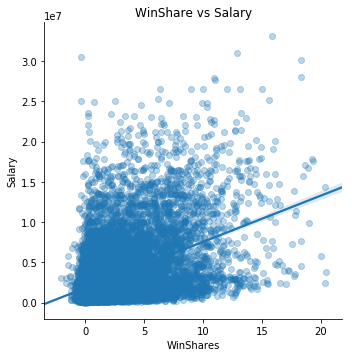

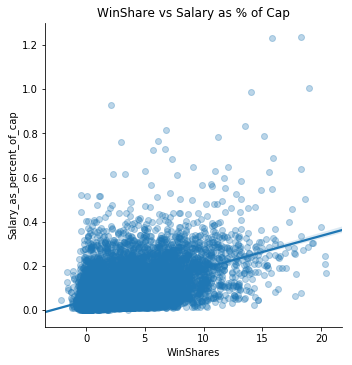

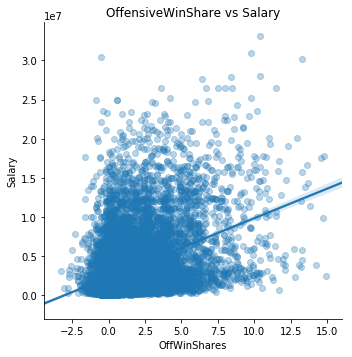

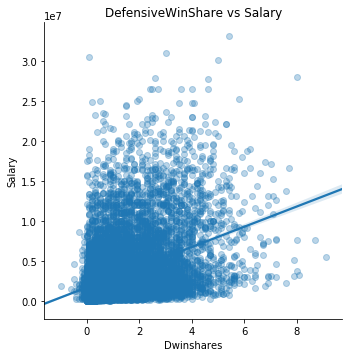

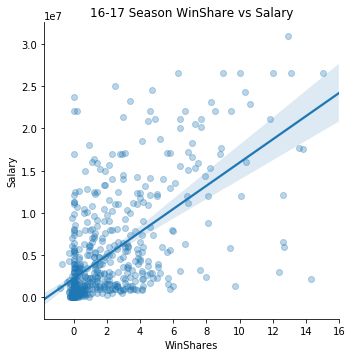

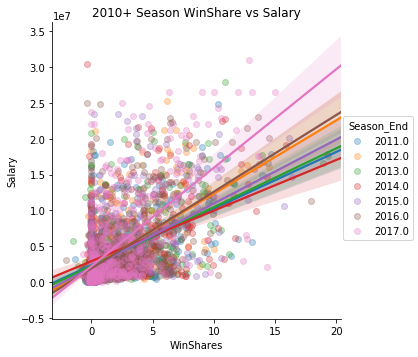

In [70]:
#Salary vs WinShares

morethan70minperseason = data.loc[data.loc[:, 'MinPlayed'] >= 70, :]

sns.lmplot(data=morethan70minperseason, x='WinShares', y='Salary', scatter_kws={'alpha':0.3})
ax = plt.gca()
ax.set_title("WinShare vs Salary")

sns.lmplot(data=morethan70minperseason, x='WinShares', y='Salary_as_percent_of_cap', scatter_kws={'alpha':0.3})
ax = plt.gca()
ax.set_title("WinShare vs Salary as % of Cap")

sns.lmplot(data=morethan70minperseason, x = 'OffWinShares', y='Salary', scatter_kws={'alpha':0.3})
ax = plt.gca()
ax.set_title("OffensiveWinShare vs Salary")

sns.lmplot(data=morethan70minperseason, x = 'Dwinshares', y='Salary', scatter_kws={'alpha':0.3})
ax = plt.gca()
ax.set_title("DefensiveWinShare vs Salary")

sns.lmplot(data=data.loc[data.loc[:, 'Season_End'] == 2017, :], x='WinShares', y='Salary', scatter_kws={'alpha':0.3})
ax = plt.gca()
ax.set_title("16-17 Season WinShare vs Salary");

sns.lmplot(data=data.loc[data.loc[:, 'Season_End'] > 2010, :], 
           x='WinShares', 
           y='Salary', 
           hue = 'Season_End', 
           scatter_kws={'alpha':0.3})
ax = plt.gca()
ax.set_title("2010+ Season WinShare vs Salary");

In [23]:
print('Salary vs Win Share correlation:', data.loc[:, 'Salary'].corr(data.loc[:, 'WinShares']))
print('Salary vs Offensive Win Share correlation:', data.loc[:, 'Salary'].corr(data.loc[:, 'OffWinShares']))
print('Salary vs Defensive Win Share correlation:', data.loc[:, 'Salary'].corr(data.loc[:, 'Dwinshares']))

Salary vs Win Share correlation: 0.4455630897398196
Salary vs Offensive Win Share correlation: 0.4276886920788764
Salary vs Defensive Win Share correlation: 0.4257576353139876


# Modeling!

In [121]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

#Using just box score features

modeldata = data.loc[(data.loc[:, 'next_season_salary'].notnull()) & (data.loc[:, 'Games'] > 0), :]

X = modeldata.loc[:, box_score_features]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

scaler = StandardScaler()
X = scaler.fit_transform(X)

linreg = LinearRegression()
linreg.fit(X, y)

score = (cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))

np.mean(np.sqrt(-score))

0.0601945885773561

In [86]:
# Using just box score %s
X = modeldata.loc[:, box_score_percentages]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

scaler = StandardScaler()
X = scaler.fit_transform(X)

linreg = LinearRegression()
linreg.fit(X, y)

score = (cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))

np.mean(np.sqrt(-score))

0.07300670150966569

In [87]:
# Using just combo stats
X = modeldata.loc[:, combo_features]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

scaler = StandardScaler()
X = scaler.fit_transform(X)

linreg = LinearRegression()
linreg.fit(X, y)

score = (cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))

np.mean(np.sqrt(-score))

0.06330087110815319

In [88]:
# Predicting next season winshares based on next season salary + current year box scores
X = modeldata.loc[:, box_score_percentages]
y = modeldata.loc[:, 'next_season_winshares']

scaler = StandardScaler()
X = scaler.fit_transform(X)

linreg = LinearRegression()
linreg.fit(X, y)

score = (cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))

np.mean(np.sqrt(-score))

2.691788117751715

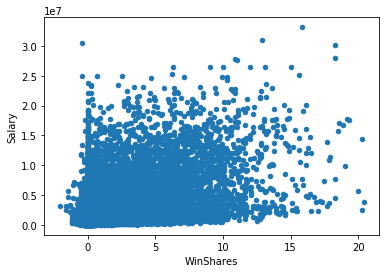

In [123]:
data.plot(kind='scatter', x='WinShares', y='Salary')

In [31]:
data.groupby('Player')['FG%'].rolling(3).mean().reset_index(0,drop=True)


0             NaN
1             NaN
2        0.476667
3        0.496333
4        0.505000
5        0.514333
6        0.496667
7        0.490333
8        0.481333
9        0.482000
10       0.472000
11       0.453667
12       0.440667
13       0.437667
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19       0.255667
20            NaN
21            NaN
22            NaN
23       0.368333
24       0.361667
25       0.380667
26       0.391667
27       0.407667
28       0.358333
29       0.305667
           ...   
15088    0.457000
15089    0.499000
15090    0.544000
15091         NaN
15092         NaN
15093    0.347333
15094    0.452333
15095    0.427000
15096    0.460333
15097    0.460667
15098    0.346000
15099         NaN
15100         NaN
15101    0.342000
15102         NaN
15103         NaN
15104    0.406667
15105         NaN
15106         NaN
15107    0.504667
15108    0.473667
15109    0.451000
15110    0.449667
15111    0.464000
15112    0

Using Decision Tree to come up with best features for the model

In [60]:
from sklearn.tree import DecisionTreeRegressor

feature_cols = ['Age_seasonEnd','Games','GamesStarted','MinPlayed',
                      'Fgmade','Fgattempt','3PtMade','3PtAttempt','2PMade','2PAttempt',
                      'FTMade','FTAttempt','Offrb','Drebounds','TotalRbnds','Assists',
                      'Steals','Blocks','Turnover','PersonalFouls','Pts','Position_Mapped', 'Years_Playing',
                      'OffRb%','Drebound%','TotalRbnd%','Assist%','Steal%','Block%','Turnover%','Usg%',
                      '3Pt%','2Pt%','FT%']
modeldata = data.loc[(data.loc[:, 'next_season_salary'].notnull()) & (data.loc[:, 'MinPlayed'] > 140), :]

X = modeldata.loc[:, feature_cols]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.06823308990959345

In [79]:
from sklearn import metrics
import numpy as np

#NULL MODEL Predicts all salary as % of cap is just salary evenly split across 12 players on the team

modeldata.loc[:, 'prediction'] = .083333
np.sqrt(metrics.mean_squared_error(modeldata.next_season_salary_as_percent_of_cap, modeldata.prediction))

C:\Users\testr\Anaconda\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.08291385424139433

In [63]:
# List of values to try:
max_depth_range = list(range(1, 10))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use LOOCV with each value of max_depth.
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

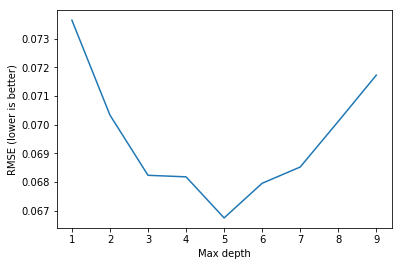

In [64]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('Max depth')
plt.ylabel('RMSE (lower is better)');

In [65]:
treereg = DecisionTreeRegressor(max_depth=5, random_state=1)
treereg.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [66]:
importance = pd.DataFrame({'features': feature_cols, 'importance':treereg.feature_importances_})
importance.sort_values('importance', ascending=False)

,features,importance
20,Pts,4.678713e-01
2,GamesStarted,9.944003e-02
22,Years_Playing,9.894937e-02
11,FTAttempt,8.112401e-02
4,Fgmade,6.212167e-02
30,Usg%,4.246151e-02
13,Drebounds,2.628280e-02
10,FTMade,2.454865e-02
24,Drebound%,2.322674e-02
28,Block%,1.931689e-02


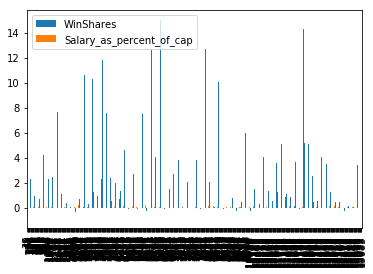

In [115]:
salpercentbyteam = data.loc[(data.loc[:, 'Stats_SeasonEnd'] == 2017), ['Team', 'WinShares','Salary_as_percent_of_cap']]
fig, ax = plt.subplots()
salpercentbyteam.plot(kind='bar', ax=ax);

In [76]:
data.groupby(['Position','Stats_SeasonEnd'])['Salary'].mean().unstack()

Stats_SeasonEnd,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,...,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0
Position,,,,,,,,,,,,,,,,,,,,,
C,1.613229e+06,1.165498e+06,1.116758e+06,1.363089e+06,1.407765e+06,1.766216e+06,1.849963e+06,1.877597e+06,2.670378e+06,2.999567e+06,...,4.656862e+06,4.412407e+06,4.911566e+06,4.315883e+06,4.644289e+06,4.329012e+06,4.831037e+06,4.849882e+06,4.663288e+06,5.893948e+06
C-PF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.652593e+06,NaN,4.711613e+06,2.015773e+06,8.231334e+05,3.427264e+06,NaN,NaN,NaN,NaN
C-SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.953687e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PF,1.539935e+06,9.000655e+05,1.104189e+06,1.235126e+06,1.341404e+06,1.670923e+06,1.562050e+06,1.899931e+06,2.135000e+06,2.846599e+06,...,4.183028e+06,4.191096e+06,4.119272e+06,4.411673e+06,3.876903e+06,4.434302e+06,4.302160e+06,4.198373e+06,4.697192e+06,5.234882e+06
PF-C,NaN,NaN,NaN,8.941667e+05,NaN,NaN,1.004074e+06,1.638259e+06,NaN,1.224312e+06,...,NaN,6.278889e+06,3.959280e+06,NaN,NaN,2.846051e+06,NaN,NaN,5.067102e+06,1.736573e+06
PF-SF,NaN,NaN,3.074167e+05,1.400000e+05,NaN,NaN,NaN,NaN,NaN,NaN,...,4.172979e+05,6.317857e+06,2.160238e+06,7.772971e+06,3.390334e+06,3.056464e+06,2.731992e+06,1.867085e+06,NaN,NaN
PG,1.419305e+06,8.127241e+05,1.056927e+06,8.869465e+05,1.022667e+06,1.304358e+06,1.534852e+06,1.956121e+06,1.936845e+06,1.846613e+06,...,3.677636e+06,3.907739e+06,3.119720e+06,4.226546e+06,2.992401e+06,3.259496e+06,3.707255e+06,3.596048e+06,3.790054e+06,4.991883e+06
PG-SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PG-SG,NaN,NaN,1.445078e+06,6.725000e+05,NaN,NaN,NaN,NaN,NaN,NaN,...,5.932522e+06,3.776942e+06,1.270797e+06,3.086735e+06,NaN,1.238746e+06,NaN,5.699020e+06,NaN,NaN


In [89]:
feature_cols_importance = ['Pts', 'GamesStarted', 'Years_Playing', 'FTAttempt', 'Fgmade', 'Usg%', 'Drebounds', 'FTMade', 
                          'Drebound%', 'Block%', 'Offrb', 'Games', 'TotalRbnd%', 'Assists', 'Age_SeasonEnd']

X = modeldata.loc[:, feature_cols_importance]
y = modeldata.loc[:, 'next_season_salary_as_percent_of_cap']

scaler = StandardScaler()
X = scaler.fit_transform(X)

linreg = LinearRegression()
linreg.fit(X, y)

score = (cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))

np.mean(np.sqrt(-score))

C:\Users\testr\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
C:\Users\testr\Anaconda\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#Second model: given this year stats & next year salary, what win shares can we expect?
#Use random forest?